# Multi agent collaboration patterns
Shows the skeleton code for collaboration patterns.

https://blog.langchain.com/langgraph-multi-agent-workflows/

### Business use case

A retailer deals with multiple product categories. Retailer is looking to build a customer service system that would streamline the customer service. 

### Comparison


| Feature               | **Swarm Pattern**                     | **Hierarchical Pattern**             | **Supervisor Pattern**               |
|-----------------------|--------------------------------------|--------------------------------------|--------------------------------------|
| **Control Flow**      | Decentralized, parallel              | Tree-structured, top-down            | Centralized supervisor, dynamic      |
| **Decision Making**   | Voting/consensus among agents        | Parent agents synthesize child outputs | Supervisor evaluates & combines      |
| **Agent Awareness**   | Agents unaware of others             | Child agents unaware of siblings     | Workers unaware of supervisor logic  |
| **Workflow**          | All agents run simultaneously        | Rigid parent-child delegation        | Adaptive (tasks assigned on-demand) |
| **Pros**              | Fast (parallel), resilient           | Clear accountability                 | Highly adaptable, context-aware     |
| **Cons**              | No global context, hard to debug     | Inflexible to workflow changes       | Supervisor = single point of failure |
| **Best For**          | Problems needing diverse perspectives | Mirroring org structures             | Complex, conditional workflows      |
| **Analogy**           | Bee swarm (collective intelligence)  | Corporate org chart                  | Air traffic control (dynamic routing) |
| **Example Query Handling** | Agents vote on return eligibility  | Director delegates to specialized teams | Supervisor skips sentiment check if policy denies returns |
| **Code Reuse**        | Original agents vote independently    | Original agents become leaf nodes    | Original agents as supervised workers |

---

### **Key Takeaways**:
1. **Supervisor** → Best for complex, conditional workflows
2. **Hierarchical** → Best for mirroring real-world hierarchies  
3. **Swarm** → Best for quick, collective decisions

Each pattern trades off flexibility vs. control, parallelism vs. coordination. Choose based on your problem’s needs!

## 0. Dummy sub agents

In [7]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random


def orders_history_agent(messages):
    """Writes customer's orders history to the blackboard"""
    orders = [{"order":1, "items":[1,2,3]}] # Just a sample
    return {"customer_orders": orders}

def policy_check_agent(messages):
    """Writes return policy for the product to the blackboard"""
    policy = ["30-day return"] # Just a sample
    return {"return_policy": policy}

def sentiment_analyzer_agent(messages):
    """Writes sentiment analysis to blackboard"""
    moods = ["Normal", "Urgent", "Escalate"] # Just a sample
    return {"customer_sentiment": random.choice(moods)}

## 1. Agent as tool

In [ ]:
@tool
def order_history_tool(customer_id):
    message

## 1. Supervisor agent

#### Working
The **Supervisor Agent** acts as an intelligent orchestrator that dynamically manages a team of specialized worker agents. Unlike rigid hierarchical or swarm approaches, the supervisor:

1. **Controls Workflow Logic**  
   - Decides which agents to activate (and in what order)  
   - Can skip unnecessary steps (e.g., if policy says "no returns," it won’t check sentiment)  
   - Maintains full context of the process  

2. **Key Responsibilities**  
   - **Task Assignment**: Identifies missing information (e.g., no policy check → activates policy agent)  
   - **Result Synthesis**: Combines worker outputs into a final decision  
   - **Error Handling**: Could retry failed tasks or escalate issues  

3. **Worker Agent Interaction**  
   - Workers (like your original agents) remain single-purpose and unaware of the supervisor  
   - All workers report back to the supervisor, never directly to each other  

4. **Adaptive Execution**  
   ```mermaid
   graph TB
     S(Supervisor) -->|"Need product info?"| A(Order Agent)
     S -->|"Need policy?"| B(Policy Agent)
     S -->|"Need sentiment?"| C(Sentiment Agent)
     A --> S
     B --> S
     C --> S
     S --> O(Output)
   ```

5. **When to Use This Pattern**  
   - When tasks have complex dependencies  
   - If some steps are optional (e.g., skip sentiment check for happy customers)  
   - For workflows requiring real-time adjustments  

**Example Scenario**:  
For the query *"I want to return these shoes"*, the supervisor:  
1. Activates the order agent → Confirms product eligibility  
2. Activates policy agent → Finds "30-day return" policy  
3. **Skips sentiment analysis** (not needed for standard returns)  
4. Automatically approves the return  

This pattern combines the flexibility of swarm agents with the control of hierarchical systems, making it ideal for dynamic, real-world scenarios.

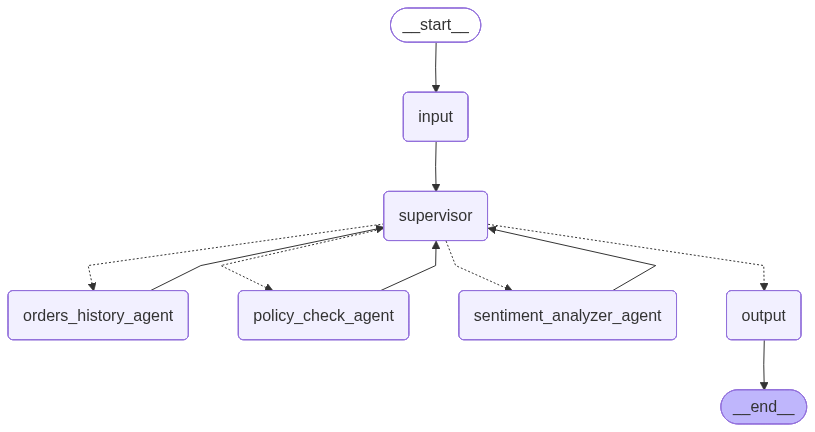

In [10]:


# State management 
class SupervisorState:
    query: str
    product_info: str = ""
    return_policy: str = ""
    customer_sentiment: str = ""
    current_task: str = ""
    final_answer: str = ""

# Create the agent using graph
workflow = StateGraph(SupervisorState)


# --- Supervisor Agent ---
def supervisor_agent(state):
    """Orchestrates the workflow by assigning tasks"""
    # Determine next task based on missing information
    if not state.product_info:
        return {"current_task": "orders_history_agent"}
    elif not state.return_policy:
        return {"current_task": "policy_check_agent"}
    elif not state.customer_sentiment:
        return {"current_task": "sentiment_analyzer_agent"}
    else:
        # All data collected - make final decision
        conclusion = (
            f"SUPERVISOR'S DECISION:\n"
            f"• Product Status: {state.product_info}\n"
            f"• Return Policy: {state.return_policy}\n"
            f"• Customer Priority: {state.customer_sentiment}\n"
            f"OUTCOME: {'Approved' if '30-day' in state.return_policy else 'Denied'}"
        )
        return {"final_answer": conclusion, "current_task": None}

# --- Build Workflow ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("orders_history_agent", orders_history_agent)
workflow.add_node("policy_check_agent", policy_check_agent)
workflow.add_node("sentiment_analyzer_agent", sentiment_analyzer_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Supervisor Pattern Edges ---
workflow.set_entry_point("input")
workflow.add_edge("input", "supervisor")

# Dynamic task routing
workflow.add_conditional_edges(
    "supervisor",
    lambda state: state.current_task or "output",  # Default to output if no task
    {
        "orders_history_agent": "orders_history_agent",
        "policy_check_agent": "policy_check_agent",
        "sentiment_analyzer_agent": "sentiment_analyzer_agent",
        "output": "output"
    }
)

# All workers report back to supervisor
workflow.add_edge("orders_history_agent", "supervisor")
workflow.add_edge("policy_check_agent", "supervisor")
workflow.add_edge("sentiment_analyzer_agent", "supervisor")

workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app

## 2. Hierarchical 

Here’s a simple definition of the **Hierarchical Multi-Agent Pattern**:  

**The Hierarchical Multi-Agent Pattern** organizes agents into a tree-like structure where higher-level "manager" agents delegate tasks to lower-level "worker" agents, then synthesize their results. Like a corporate hierarchy, decisions flow top-down (from generalists to specialists), while data flows bottom-up (from specialists back to decision-makers).  

### Key Features:  
1. **Layered Authority** – Clear chain of command (e.g., Director → Teams → Specialists).  
2. **Task Delegation** – Managers break problems into subtasks for workers.  
3. **Centralized Synthesis** – Top-level agents combine results into final decisions.  
4. **Reusability** – Workers (like your original agents) stay focused on narrow tasks.  

**Analogies**:  
- Like a company (CEO → Departments → Employees)  
- Like a nervous system (Brain → Spinal Cord → Nerves)  

**When to Use**:  
- For complex problems needing structured coordination  
- When some work streams require deeper decomposition than others 
- To mirror real-world organizational designs where executives directly oversee key domain pods alongside functional managers (e.g., customer support with specialist escalation teams)

### Use case

The workflow below implements a **hierarchical customer support decision system for return requests**.

A **Director agent** receives a customer query (“Can I return this?”, “My headphones stopped working after a week. Am I eligible for a return?”, “I’m unhappy with this product. Can I get a refund?”, “This was a gift and I don’t have the receipt. What are my return options?”) and delegates work across two branches:

* A **Product specialist branch**, where a Product Manager coordinates workers to gather **order history** and **product details**, then consolidates them into product context.
* An **Operations branch**, where an Operations Manager coordinates sub-agents to extract the **return policy** and analyze **customer sentiment**.

All findings flow back to the Director, who **synthesizes product context, policy constraints, and customer sentiment** to produce a final decision on whether the return is approved or denied.


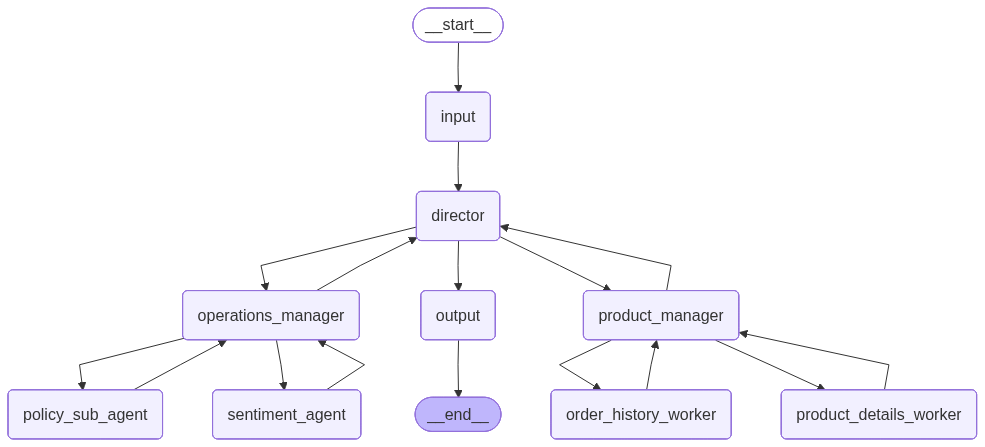

In [3]:
from langgraph.graph import StateGraph
from typing import TypedDict

# -----------------------------
# State
# -----------------------------
class HierarchicalState(TypedDict, total=False):
    query: str
    product_info: str
    return_policy: str
    customer_sentiment: str
    product_details: str
    order_history: str
    policy_extracted: str
    final_answer: str


# -----------------------------
# Level 3 — Workers (under Product Sub-Manager)
# -----------------------------
def order_history_worker(state: HierarchicalState):
    return {"order_history": "Order #1234, purchased 10 days ago"}

def product_details_worker(state: HierarchicalState):
    return {"product_details": "Wireless headphones, electronics category"}

# -----------------------------
# Level 2 — Sub-manager and sub-agent
# -----------------------------
def product_manager(state: HierarchicalState):
    combined = f"{state.get('product_details','')} | {state.get('order_history','')}"
    return {"product_info": combined}

def policy_sub_agent(state: HierarchicalState):
    return {"policy_extracted": "30-day return policy for electronics"}

# -----------------------------
# Level 1 — Manager (non-product branch)
# -----------------------------
def operations_manager(state: HierarchicalState):
    return {
        "return_policy": state.get("policy_extracted", ""),
        "customer_sentiment": state.get("customer_sentiment", "")
    }

# -----------------------------
# Supporting agent
# -----------------------------
def sentiment_agent(state: HierarchicalState):
    return {"customer_sentiment": "Customer is frustrated but polite"}

# -----------------------------
# Level 0 — Director
# -----------------------------
def director_agent(state: HierarchicalState):
    if state.get("product_info") and state.get("return_policy"):
        decision = (
            f"DIRECTOR DECISION\n"
            f"- Product: {state['product_info']}\n"
            f"- Policy: {state['return_policy']}\n"
            f"- Sentiment: {state.get('customer_sentiment','')}\n"
            f"Conclusion: {'Approved' if '30-day' in state['return_policy'] else 'Denied'}"
        )
        return {"final_answer": decision}
    return {}

# -----------------------------
# Graph
# -----------------------------
workflow = StateGraph(HierarchicalState)

workflow.add_node("input", lambda state: {"query": "Can I return this?"})

# Workers
workflow.add_node("order_history_worker", order_history_worker)
workflow.add_node("product_details_worker", product_details_worker)

# Level 2
workflow.add_node("product_manager", product_manager)
workflow.add_node("policy_sub_agent", policy_sub_agent)

# Level 1
workflow.add_node("sentiment_agent", sentiment_agent)
workflow.add_node("operations_manager", operations_manager)

# Level 0
workflow.add_node("director", director_agent)
workflow.add_node("output", lambda state: print(state["final_answer"]))

# -----------------------------
# Hierarchy wiring
# -----------------------------
workflow.set_entry_point("input")

# Director entry
workflow.add_edge("input", "director")

# Director → Level 1 & Level 2
workflow.add_edge("director", "product_manager")
workflow.add_edge("director", "operations_manager")

# Product branch
workflow.add_edge("product_manager", "order_history_worker")
workflow.add_edge("product_manager", "product_details_worker")
workflow.add_edge("order_history_worker", "product_manager")
workflow.add_edge("product_details_worker", "product_manager")
workflow.add_edge("product_manager", "director")

# Operations branch
workflow.add_edge("operations_manager", "policy_sub_agent")
workflow.add_edge("operations_manager", "sentiment_agent")
workflow.add_edge("policy_sub_agent", "operations_manager")
workflow.add_edge("sentiment_agent", "operations_manager")
workflow.add_edge("operations_manager", "director")

# Final
workflow.add_edge("director", "output")
workflow.set_finish_point("output")

# -----------------------------
# Compile
# -----------------------------
app = workflow.compile()
app


## 3. Swarm pattern

The Swarm Pattern is a decentralized, multi-agent approach where several specialized agents work in parallel on the same problem. Each agent contributes a perspective, partial solution, or vote, and a consensus mechanism (such as majority voting, weighted scoring, or confidence aggregation) integrates their outputs into a final decision.

👉 The key aspects are:

Decentralization – no single agent controls the process.

Parallelism – multiple agents work simultaneously.

Consensus – outputs are merged into one reliable result.

#### Working 

The system starts with a customer query (e.g., *"Can I return this?"*). Instead of working step-by-step, **three specialized agents activate simultaneously**—each tackling a different aspect:  
- The **order history agent** checks product eligibility (e.g., *"Nike, returnable"*).  
- The **policy agent** reviews store rules (e.g., *"30-day return window"*).  
- The **sentiment agent** gauges customer urgency (e.g., *"Escalate: angry customer"*).  

Each agent submits its answer with a confidence score to a shared pool. A **consensus agent** then tallies the results—like a voting system—and combines the most agreed-upon answers into a final response (e.g., *"Consensus: Return allowed within 30 days (High urgency)."*). Unlike the blackboard’s linear flow, the swarm works in parallel, with agents debating to reach collective agreement.  

### **Example Queries for the Swarm Pattern:**  
1. *"Is my purchase refundable?"*  
   - Agents check product status, policy, and tone simultaneously.  
2. *"I hate this item—give me my money back NOW."*  
   - Sentiment agent flags urgency while policy agent confirms rules.  
3. *"What brands allow exchanges?"*  
   - Order history and policy agents collaborate on brand-specific rules.  
4. *"The website said free returns—is that true?"*  
   - Policy agent verifies, while sentiment detects confusion/frustration.  

**Key Difference:** The swarm thrives on speed (parallel processing) and collective decision-making, while the blackboard is methodical (sequential with a controller). The swarm is ideal when multiple perspectives (e.g., policy + sentiment) need equal weight.

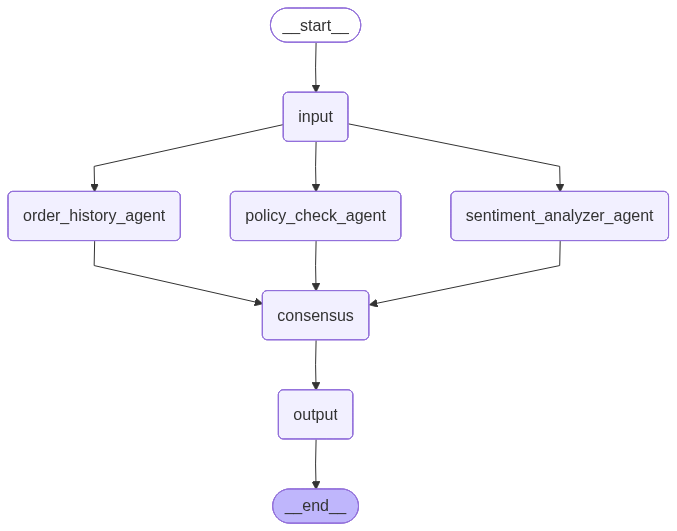

In [4]:
from langgraph.graph import StateGraph
from typing import Dict, List
import random

# State = Our decentralized blackboard
class SwarmState:
    query: str
    partial_answers: List[Dict] = []  # Collective knowledge pool
    consensus_threshold: int = 3      # Min votes for consensus
    final_answer: str = ""

# Initialize the swarm
workflow = StateGraph(SwarmState)



# --- Voting/Consensus Mechanism ---
def swarm_consensus_agent(state):
    """Aggregates partial answers through simple voting"""
    if len(state.partial_answers) >= state.consensus_threshold:
        # Simple majority vote (real impl would use confidence-weighted voting)
        product_answers = [a for a in state.partial_answers if a["type"] == "product"]
        final_product = max(set([a["answer"] for a in product_answers]), 
                          key=[a["answer"] for a in product_answers].count)
        
        return {"final_answer": f"Consensus: {final_product}"}
    return {}

# --- Add Nodes ---
workflow.add_node("input", lambda state: {"query": "Can I return this?"})
workflow.add_node("order_history_agent", order_history_agent_agent)
workflow.add_node("policy_check_agent", policy_check_agent_agent) 
workflow.add_node("sentiment_analyzer_agent", sentiment_analyzer_agent_agent)
workflow.add_node("consensus", swarm_consensus_agent)
workflow.add_node("output", lambda state: print(state.final_answer))

# --- Swarm-Specific Edges ---
workflow.set_entry_point("input")

# Parallel agent activation
workflow.add_edge("input", "order_history_agent")
workflow.add_edge("input", "policy_check_agent")
workflow.add_edge("input", "sentiment_analyzer_agent")

# Collective decision-making
workflow.add_edge("order_history_agent", "consensus")
workflow.add_edge("policy_check_agent", "consensus") 
workflow.add_edge("sentiment_analyzer_agent", "consensus")

workflow.add_edge("consensus", "output")
workflow.set_finish_point("output")

# --- Visualize ---
app = workflow.compile()
app